# Improving the model

Trying to take a look at a rolling window of games to see if more recent performance has a stronger impact on games

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [51]:
games = pd.read_csv('data/01_prediction_model.csv')
games["GAME_DATE_EST"] = pd.to_datetime(games["GAME_DATE_EST"])
games["GAME_DATETIME"] = games["GAME_DATE_EST"].astype(int)

In [52]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8284 entries, 0 to 8283
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   GAME_DATE_EST      8284 non-null   datetime64[ns]
 1   GAME_ID            8284 non-null   int64         
 2   HOME_TEAM_ID       8284 non-null   int64         
 3   AWAY_TEAM_ID       8284 non-null   int64         
 4   SEASON             8284 non-null   int64         
 5   HOME_TEAM_POINTS   8284 non-null   int64         
 6   AWAY_TEAM_POINTS   8284 non-null   int64         
 7   HOME_WIN_PCT       8284 non-null   float64       
 8   HOME_HOME_WIN_PCT  8284 non-null   float64       
 9   AWAY_WIN_PCT       8284 non-null   float64       
 10  AWAY_AWAY_WIN_PCT  8284 non-null   float64       
 11  HOME_TEAM_WINS     8284 non-null   bool          
 12  HOME_TEAM_B2B      8284 non-null   bool          
 13  AWAY_TEAM_B2B      8284 non-null   bool          
 14  GAME_DAT

In [53]:
def calc_last_n_win_pct(team_id, n):
    _game = games[(games['HOME_TEAM_ID'] == team_id) | (games['AWAY_TEAM_ID'] == team_id)]
    _game.loc[:,'IS_HOME'] = _game['HOME_TEAM_ID'] == team_id
    _game.loc[:,'WIN_PRCT'] = _game['IS_HOME'] == _game['HOME_TEAM_WINS']
    rolling_win_pct = _game["WIN_PRCT"].rolling(n, min_periods=1).mean().rename(f"LAST_{n}_WIN_PCT")
    return pd.concat([_game["GAME_ID"], rolling_win_pct], axis=1)

def calc_game_lookback_data(game):
  home_team_id = game['HOME_TEAM_ID']
  home_last_10_win_pct = calc_last_n_win_pct(home_team_id, 10)
  home_last_10_win_pct = home_last_10_win_pct[home_last_10_win_pct["GAME_ID"] == game["GAME_ID"]]
  home_last_10_win_pct.drop(columns="GAME_ID", inplace=True)
  home_lookback_data = pd.concat([home_last_10_win_pct], axis=1).add_prefix('HOME_')

  away_team_id = game['AWAY_TEAM_ID']
  away_last_10_win_pct = calc_last_n_win_pct(away_team_id, 10)
  away_last_10_win_pct = away_last_10_win_pct[away_last_10_win_pct["GAME_ID"] == game["GAME_ID"]]
  away_last_10_win_pct.drop(columns="GAME_ID", inplace=True)
  away_lookback_data = pd.concat([away_last_10_win_pct], axis=1).add_prefix('AWAY_')

  lookback_data = pd.concat([game.to_frame().T, home_lookback_data, away_lookback_data], axis=1)
  lookback_data["HOME_TEAM_WINS"] = lookback_data["HOME_TEAM_WINS"].astype(bool)
  return lookback_data

new_games = pd.concat(games.sort_values(by="GAME_DATETIME").apply(calc_game_lookback_data, axis=1).tolist())

In [42]:
feat_cols = [
  "GAME_DATETIME",
  "HOME_TEAM_ID",
  "AWAY_TEAM_ID",
  "HOME_WIN_PCT",
  "HOME_HOME_WIN_PCT",
  "AWAY_WIN_PCT",
  "AWAY_AWAY_WIN_PCT",
  "HOME_TEAM_B2B",
  "AWAY_TEAM_B2B",
  "HOME_LAST_10_WIN_PCT",
  "AWAY_LAST_10_WIN_PCT"
]

target = "HOME_TEAM_WINS"

In [43]:
new_games[new_games["SEASON"] == 2023][feat_cols + [target]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1230 entries, 8266 to 7057
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GAME_DATETIME         1230 non-null   object 
 1   HOME_TEAM_ID          1230 non-null   object 
 2   AWAY_TEAM_ID          1230 non-null   object 
 3   HOME_WIN_PCT          1230 non-null   object 
 4   HOME_HOME_WIN_PCT     1230 non-null   object 
 5   AWAY_WIN_PCT          1230 non-null   object 
 6   AWAY_AWAY_WIN_PCT     1230 non-null   object 
 7   HOME_TEAM_B2B         1230 non-null   object 
 8   AWAY_TEAM_B2B         1230 non-null   object 
 9   HOME_LAST_10_WIN_PCT  1230 non-null   float64
 10  AWAY_LAST_10_WIN_PCT  1230 non-null   float64
 11  HOME_TEAM_WINS        1230 non-null   bool   
dtypes: bool(1), float64(2), object(9)
memory usage: 116.5+ KB


In [46]:
def calculate_season(s):
    season = new_games.loc[(new_games['SEASON'] == s)].sort_values(by="GAME_DATETIME")
    train_1, test_1, test_2 = np.array_split(season, 3)
    train = pd.concat([train_1])
    X_train, y_train = train[feat_cols], train[target]

    test = pd.concat([test_1, test_2])
    X_test, y_test = test[feat_cols], test[target]
    clf = RandomForestClassifier(random_state=42, n_jobs=2, n_estimators=1000, max_depth=7, bootstrap=True)
    clf.fit(X_train, y_train)
    print('Train accuracy:',clf.score(X_train, y_train))
    print('Test accuracy:', clf.score(X_test, y_test))
    importances = clf.feature_importances_
    plt.figure(figsize=(8, 4))
    plt.barh(feat_cols, importances, color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # Invert y-axis for better visualization
    plt.show()

/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9536585365853658
Test accuracy: 0.7402439024390244


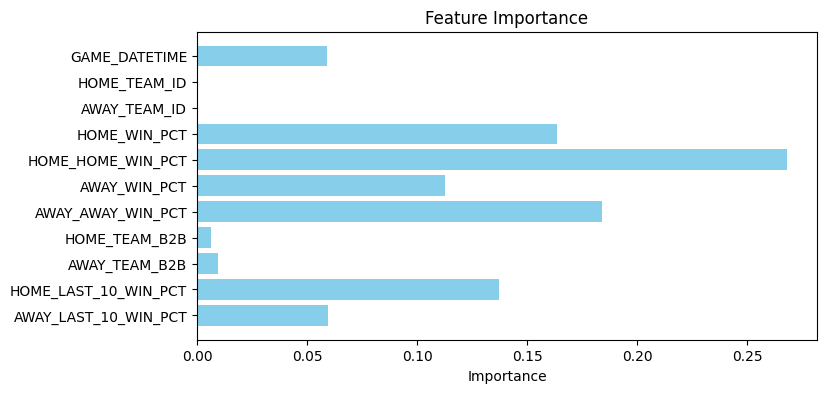

In [47]:
calculate_season(2023)

******* CALCULATING SEASON **********
2017


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.973170731707317
Test accuracy: 0.7573170731707317


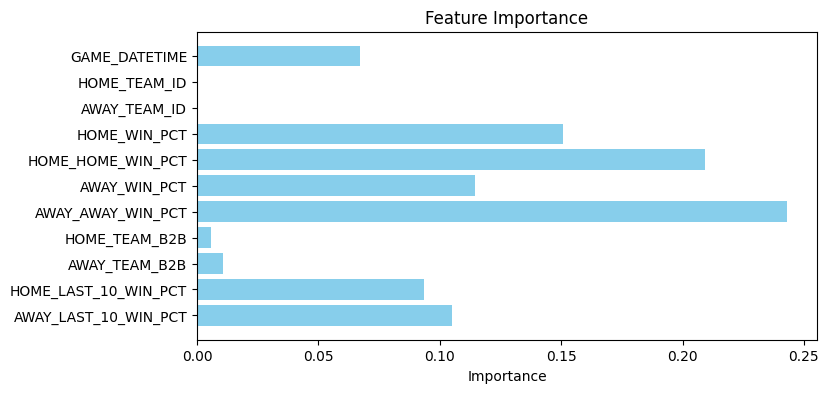

******* CALCULATING SEASON **********
2018


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9658536585365853
Test accuracy: 0.7536585365853659


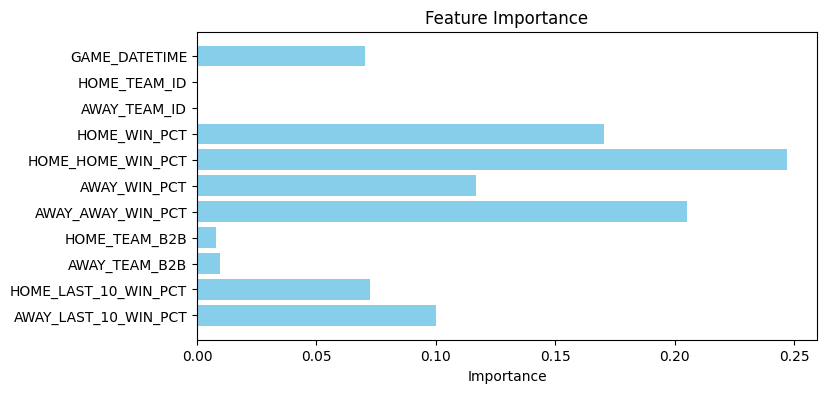

******* CALCULATING SEASON **********
2019


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9829545454545454
Test accuracy: 0.7027027027027027


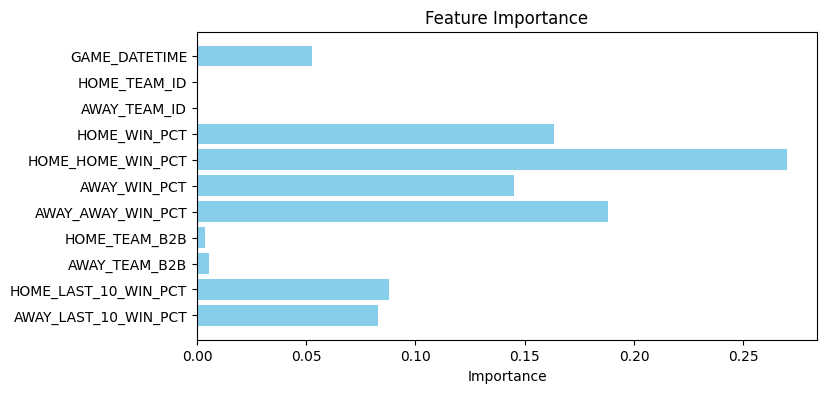

******* CALCULATING SEASON **********
2020


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9694444444444444
Test accuracy: 0.7298050139275766


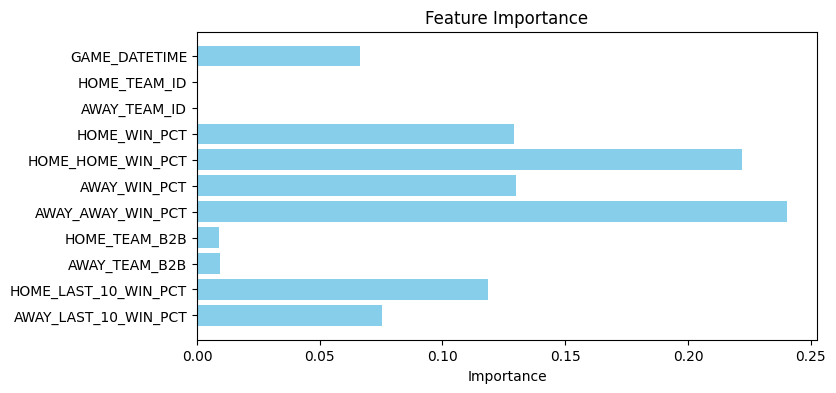

******* CALCULATING SEASON **********
2021


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9585365853658536
Test accuracy: 0.7341463414634146


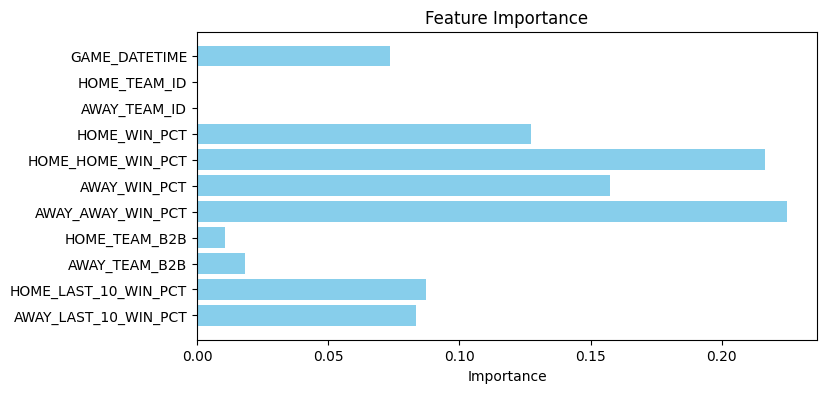

******* CALCULATING SEASON **********
2022


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9318734793187348
Test accuracy: 0.6792682926829269


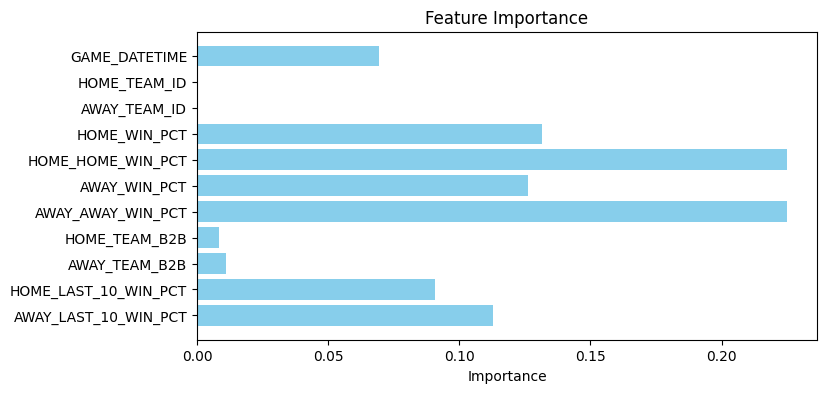

******* CALCULATING SEASON **********
2023


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9536585365853658
Test accuracy: 0.7402439024390244


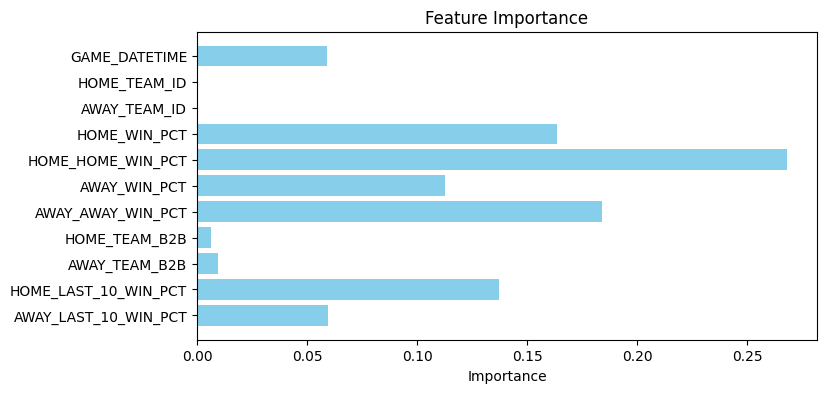

In [49]:
for i in range(2017, 2024):
    print("******* CALCULATING SEASON **********")
    print(i)
    calculate_season(i)

## Including previous 10 game win pct improves the forecasting by ~5-8%

In [54]:
games.to_csv('data/03_improved_model.csv', index=False)